## Import Libraries

In this section, we will import the necessary libraries and modules required for our project. Here's a breakdown:

- `numpy`: For numerical operations.
- `pandas`: For data manipulation and analysis.
- `torch`: PyTorch library for tensor operations and building neural networks.
- `networkx`: For creating and manipulating complex networks (graphs).
- `matplotlib`: For plotting and visualization.

For better reproducibility, it is recommended to keep track of the version of these libraries.


In [1]:
# Basic Libraries
import numpy as np  # For numerical operations
import os  # For operating system dependent functionality

# PyTorch and Related Libraries
import torch  # PyTorch library
from torch import nn  # Neural network modules
from torch.nn import Softmax  # Softmax activation function
from torcheval.metrics import MulticlassAccuracy, MulticlassConfusionMatrix  # Evaluation metrics

# Graph Neural Network Libraries
from torch_geometric.datasets import Planetoid  # Datasets for graph-based learning
from torch_geometric.nn import GCNConv  # Graph Convolutional Network layer
from torch_geometric.transforms import RandomNodeSplit  # Node splitting transformation

# Visualization Libraries
import matplotlib.pyplot as plt  # For plotting and visualization

## Load the Dataset

In this section, we will load the dataset necessary for our graph neural network model. We are using the Cora dataset, which is commonly used for citation network classification tasks.

In [2]:
# Define the number of validation and test samples
num_val = 200
num_test = 500

# Load the Cora dataset with a random node split for validation and testing
cora = Planetoid(
    root=".",  # Dataset storage location
    name="Cora",  # Dataset name
    transform=RandomNodeSplit(
        num_val=num_val,
        num_test=num_test,
    )
)

# Load the first graph in the dataset
data = cora[0]

# Display some basic statistics about the dataset
print('Number of nodes:', data.x.shape[0])
print('Number of edges:', data.edge_index.shape[1])
print('Number of features:', cora.num_features)
print('Number of classes:', cora.num_classes)

Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7


## Initialize the Graph Neural Network

In this section, we initialize the Graph Neural Network (GNN) model for node classification. We opt for a Graph Convolutional Network (GCN) which is effective for semi-supervised classification on graph-structured data. The GCN model excels at leveraging the graph structure to incorporate information from neighboring nodes.

In [3]:
class GCN(nn.Module):
    """
    Defines the Graph Convolutional Network (GCN) for node classification.
    """
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)  # For reproducibility
        
        # First graph convolutional layer with input and output dimensions
        self.conv1 = GCNConv(cora.num_features, 500)
        
        # Second graph convolutional layer
        self.conv2 = GCNConv(500, 100)
        
        # Third graph convolutional layer mapping to the number of classes
        self.conv3 = GCNConv(100, cora.num_classes)
        
        # Softmax classifier for the final layer
        self.classifier = Softmax(dim=1)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        """
        Forward propagation logic.
        """
        # First Convolutional Layer followed by Tanh activation
        h = self.conv1(x, edge_index)
        h = h.tanh()
        
        # Second Convolutional Layer followed by Tanh activation
        h = self.conv2(h, edge_index)
        h = h.tanh()
        
        # Third Convolutional Layer followed by Tanh activation
        h = self.conv3(h, edge_index)
        h = h.tanh()
        
        # Apply the softmax classifier
        h = self.classifier(h)
        
        return h

## Define the Forward Propagation Logic

The `forward()` function is crucial in any PyTorch `nn.Module` as it defines the forward propagation logic of the network. In this task, we have already incorporated the `forward()` function in the GCN class definition in the previous cell.

## Define the Training Function

In this section, we define a custom training function for our GCN model. Having a well-defined training function allows us to have better control over the training process, enabling techniques like batch normalization, dropout, or any custom logic specific to our problem.

In [4]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, criterion: nn.Module, data: torch.Tensor) -> tuple:
    """
    Train the model on the given data.
    
    Args:
    - model (nn.Module): The model to train.
    - optimizer (torch.optim.Optimizer): The optimizer for training.
    - criterion (nn.Module): The loss function.
    - data (torch.Tensor): The graph data.
    
    Returns:
    - tuple: Training and validation loss.
    """
    # Set the model in training mode
    model.train()
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass
    out = model(data.x, data.edge_index)
    
    # Compute the training loss
    train_loss = criterion(out[data.train_mask], data.y[data.train_mask])
    
    # Perform backpropagation to update weights
    train_loss.backward()
    
    # Update optimizer
    optimizer.step()
    
    # Compute the validation loss
    val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    
    return train_loss, val_loss

## Define the Evaluation Function
In this section, we define a custom evaluation function to assess the performance of our GCN model. Proper evaluation is crucial for understanding the model's strengths and weaknesses, and for comparing it with other models. We will use metrics such as accuracy and confusion matrix for our evaluation.

In [5]:
def eval(model: nn.Module, data: torch.Tensor, data_mask: torch.Tensor) -> tuple:
    """
    Evaluate the model on the given data using specified metrics.
    
    Args:
    - model (nn.Module): The model to evaluate.
    - data (torch.Tensor): The graph data.
    - data_mask (torch.Tensor): The mask to apply for evaluation.
    
    Returns:
    - tuple: Computed accuracy and confusion matrix.
    """
    # Set the model in evaluation mode
    model.eval()
    
    # Forward pass without gradient calculation
    with torch.no_grad():
        out = model(data.x, data.edge_index)
    
    # Get the predicted labels
    predicted_labels = out.argmax(dim=1)[data_mask]
    
    # Evaluate accuracy
    y = data.y[data_mask]
    acc_metric = MulticlassAccuracy()
    acc_metric.update(predicted_labels, y)
    
    # Evaluate confusion matrix
    cf_metric = MulticlassConfusionMatrix(cora.num_classes)
    cf_metric.update(predicted_labels, y)
    
    return acc_metric.compute(), cf_metric.compute()

## Modularize the Training Process

In this section, we focus on modularizing the training process into reusable functions and classes. This not only improves code reusability but also makes it easier to debug, extend, and maintain the codebase. 

In [6]:
def train_cora(test_pc: float, epochs: int) -> tuple:
    """
    Train and evaluate the model on the Cora dataset.
    
    Args:
    - test_pc (float): Percentage of data to be used for testing.
    - epochs (int): Number of training epochs.
    
    Returns:
    - tuple: Arrays containing training loss, validation loss, test accuracy, and confusion matrix.
    """
    # Initialize dataset split ratios
    num_test = int(cora.num_features * test_pc)
    num_val = int(cora.num_features * 0.1)
    
    # Load the dataset with specified splits
    dataset = Planetoid(
        ".",
        "Cora",
        split='geom-gcn',
        transform=RandomNodeSplit(
            num_val=num_val,
            num_test=num_test,
        )
    )
    data = dataset[0]
    
    # Initialize model, optimizer, and loss function
    model = GCN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    
    # Initialize arrays to store metrics
    train_loss_arr = []
    val_loss_arr = []
    test_acc_arr = []
    
    # Training loop with early stopping
    patience = 0
    epsilon = 0.0001
    for epoch in range(epochs):
        train_loss, val_loss = train(model, optimizer, criterion, data)
        train_loss_arr.append(train_loss.detach().numpy())
        
        # Early stopping logic
        if epoch == 0 or (min_val_loss - val_loss) > epsilon:
            min_val_loss = val_loss
            patience = 0
        else:
            patience += 1
            if patience >= 5:
                break
        
        val_loss_arr.append(val_loss.detach().numpy())
        
        # Evaluation
        test_acc, test_cf = eval(model, data, data.test_mask)
        test_acc_arr.append(test_acc)
        
        print(f'Epoch: {epoch} \t Training loss: {train_loss} \t Validation loss: {val_loss} \t Test accuracy: {test_acc}')
    
    return train_loss_arr, val_loss_arr, test_acc_arr, test_cf

## Train the Graph Neural Network (GNN)

In this section, we proceed to train our Graph Convolutional Network (GCN) model. Training is a crucial phase where the model learns to generalize from the given data. We will be using a learning rate of 0.01 and training the model for a specified number of epochs.

In [7]:
# Call the train_cora function to train the model on the Cora dataset.
# We allocate 30% of the data for testing and train for 100 epochs.
# The function returns arrays containing the training loss, validation loss, test accuracy, and confusion matrix.
train_loss_arr, val_loss_arr, test_acc_arr, test_cf = train_cora(0.3, 100)

Epoch: 0 	 Training loss: 1.9494953155517578 	 Validation loss: 1.950760006904602 	 Test accuracy: 0.3636363744735718
Epoch: 1 	 Training loss: 1.802183985710144 	 Validation loss: 1.8029298782348633 	 Test accuracy: 0.39627039432525635
Epoch: 2 	 Training loss: 1.7854807376861572 	 Validation loss: 1.7959812879562378 	 Test accuracy: 0.7738927602767944
Epoch: 3 	 Training loss: 1.6893246173858643 	 Validation loss: 1.6955926418304443 	 Test accuracy: 0.7925407886505127
Epoch: 4 	 Training loss: 1.6832959651947021 	 Validation loss: 1.6984339952468872 	 Test accuracy: 0.8275058269500732
Epoch: 5 	 Training loss: 1.658469557762146 	 Validation loss: 1.6635879278182983 	 Test accuracy: 0.8228438496589661
Epoch: 6 	 Training loss: 1.6431541442871094 	 Validation loss: 1.6501859426498413 	 Test accuracy: 0.8461538553237915
Epoch: 7 	 Training loss: 1.628352403640747 	 Validation loss: 1.6402543783187866 	 Test accuracy: 0.8391608595848083
Epoch: 8 	 Training loss: 1.620745062828064 	 Valid

## Plot the Results

In this section, we visualize the performance metrics to better understand the behavior of our trained model. Visualizing metrics like loss and accuracy can help in tuning the model further. We will plot the training and validation loss curves along with test accuracy over different epochs.

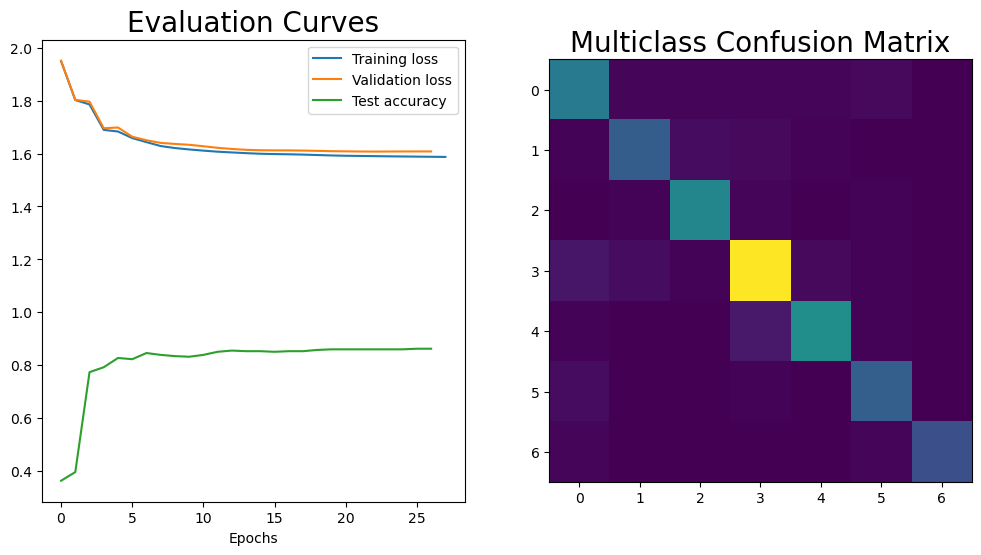


Training loss: 1.5872539281845093
Test accuracy: 0.8624708652496338


In [8]:
# Initialize a 1x2 subplot layout for plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot training loss, validation loss, and test accuracy on the first subplot
ax[0].plot(train_loss_arr, label='Training loss')
ax[0].plot(val_loss_arr, label='Validation loss')
ax[0].plot(test_acc_arr, label='Test accuracy')

# Add legend, title, and axis labels to the first subplot
ax[0].legend()
ax[0].set_title('Evaluation Curves', fontsize=20)
ax[0].set_xlabel('Epochs')

# Display the multiclass confusion matrix on the second subplot
ax[1].imshow(test_cf)
ax[1].set_title('Multiclass Confusion Matrix', fontsize=20)

# Show the plots
plt.show()

# Display the final training loss and test accuracy
print(f'\nTraining loss: {train_loss_arr[-1]}')
print(f'Test accuracy: {test_acc_arr[-1]}')

## Evaluate the Model for Different Split Ratios

In this section, we assess the robustness of our trained model by evaluating its performance under different data splits. This helps us understand how sensitive the model is to the partitioning of the dataset. We will use metrics such as accuracy and loss for this evaluation.

----------------Split ratio: 0.8:0.1:0.1------------------
Epoch: 0 	 Training loss: 1.9494757652282715 	 Validation loss: 1.948931097984314 	 Test accuracy: 0.3776223659515381
Epoch: 1 	 Training loss: 1.8021156787872314 	 Validation loss: 1.8112878799438477 	 Test accuracy: 0.3776223659515381
Epoch: 2 	 Training loss: 1.7845845222473145 	 Validation loss: 1.8060389757156372 	 Test accuracy: 0.7692307829856873
Epoch: 3 	 Training loss: 1.7025270462036133 	 Validation loss: 1.7015588283538818 	 Test accuracy: 0.8601398468017578
Epoch: 4 	 Training loss: 1.6696796417236328 	 Validation loss: 1.6644055843353271 	 Test accuracy: 0.9160839319229126
Epoch: 5 	 Training loss: 1.6594469547271729 	 Validation loss: 1.6718052625656128 	 Test accuracy: 0.9300699234008789
Epoch: 6 	 Training loss: 1.6373777389526367 	 Validation loss: 1.6478996276855469 	 Test accuracy: 0.9090909361839294
Epoch: 7 	 Training loss: 1.6257615089416504 	 Validation loss: 1.6272737979888916 	 Test accuracy: 0.9090909

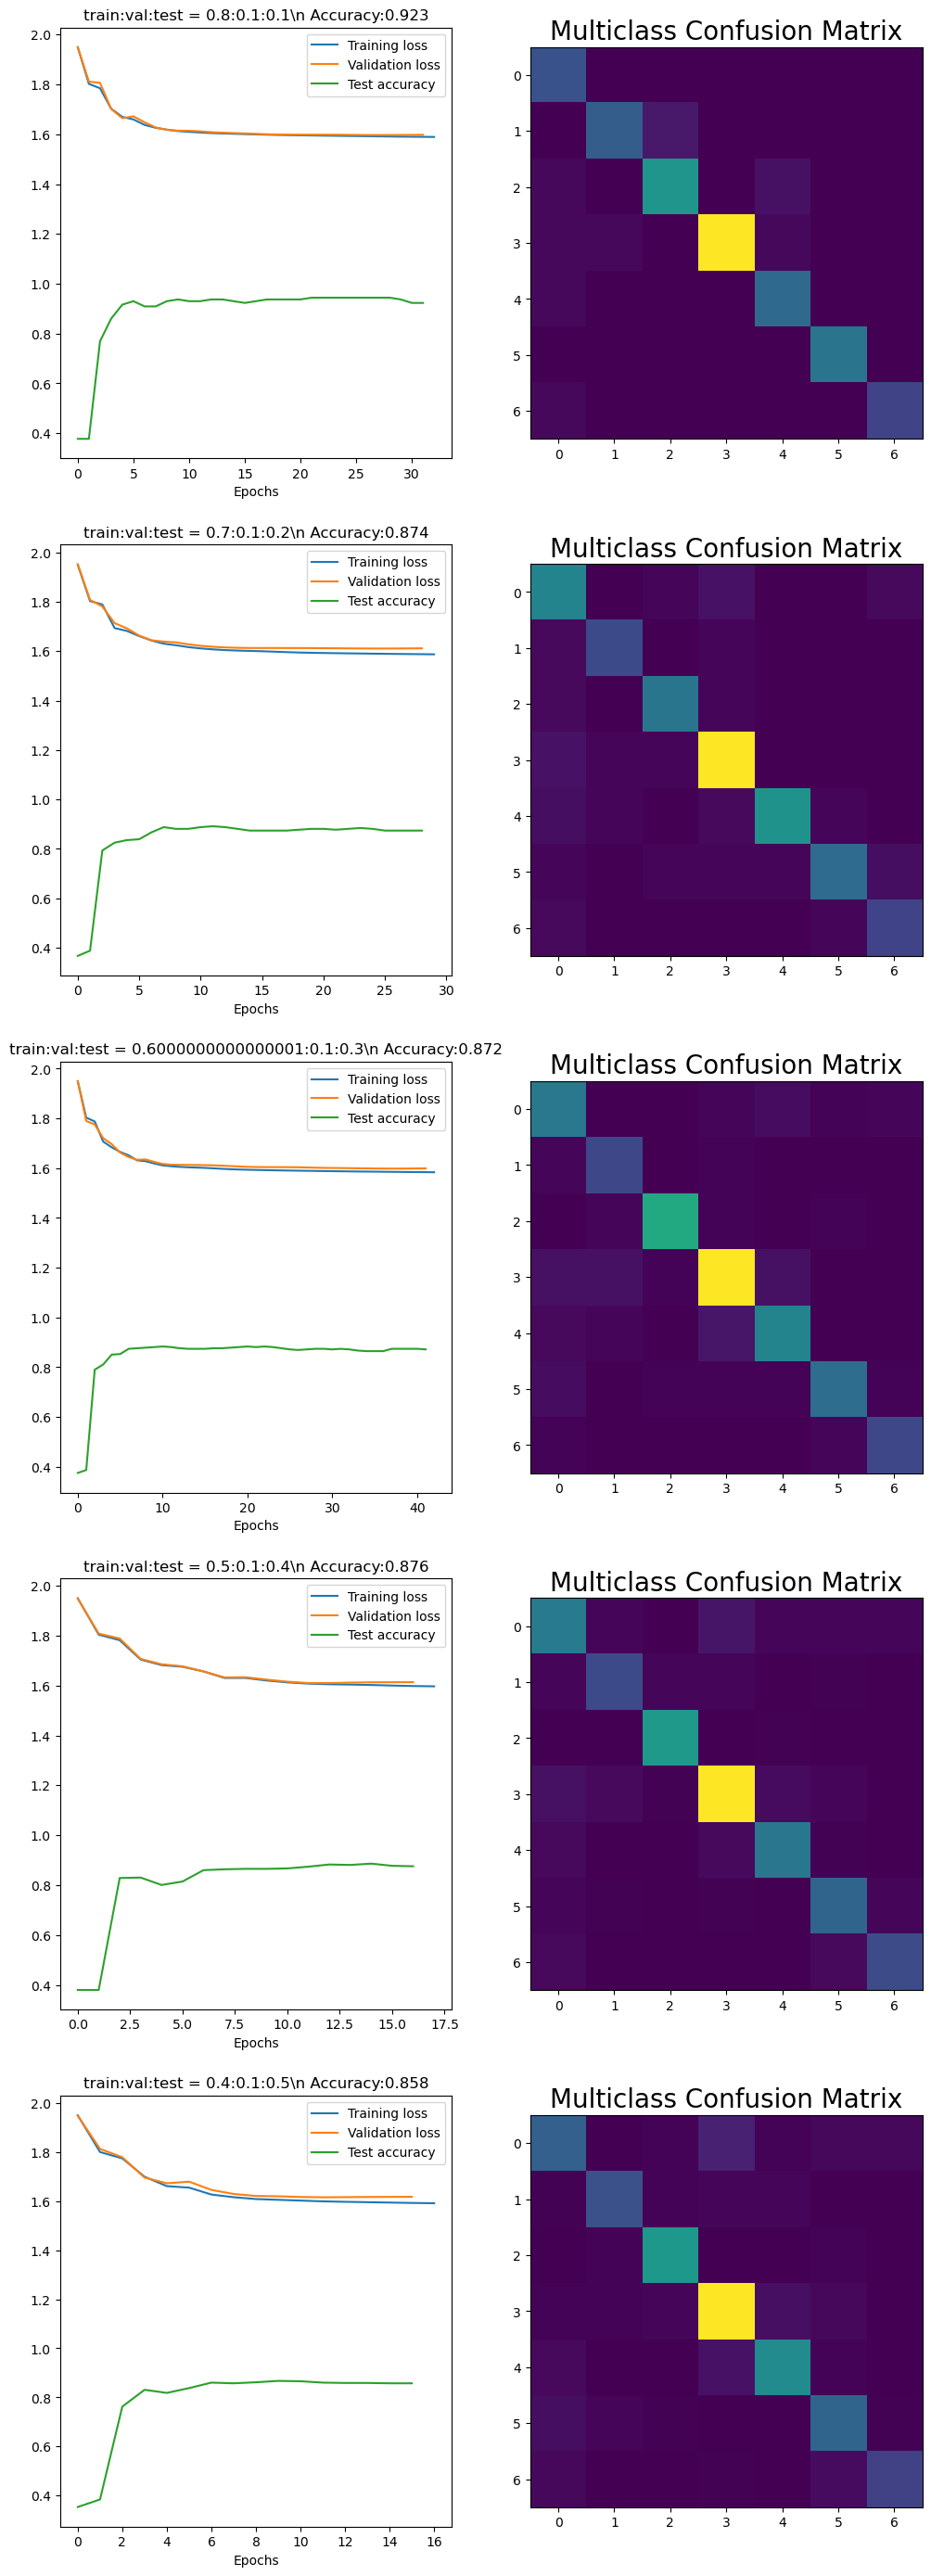

In [9]:
# Define an array of different test split ratios for evaluation
split_ratio_arr = [0.1, 0.2, 0.3, 0.4, 0.5]

# Initialize a 5x2 subplot layout for plotting
fig, ax = plt.subplots(5, 2, figsize=(12, 35))

# Loop through each test split ratio
for i, split_ratio in enumerate(split_ratio_arr):
    print(f"----------------Split ratio: {0.9 - split_ratio}:0.1:{split_ratio}------------------")
    
    # Train and evaluate the model with the current split ratio
    train_loss_arr, val_loss_arr, test_acc_arr, test_cf = train_cora(split_ratio, 100)
    
    # Plot the training loss, validation loss, and test accuracy on the first subplot
    ax[i, 0].plot(train_loss_arr, label='Training loss')
    ax[i, 0].plot(val_loss_arr, label='Validation loss')
    ax[i, 0].plot(test_acc_arr, label='Test accuracy')
    
    # Add legend, title, and axis labels to the first subplot
    ax[i, 0].legend()
    ax[i, 0].set_title(f'train:val:test = {0.9 - split_ratio}:0.1:{split_ratio}\\n Accuracy:{test_acc_arr[-1]:.3f}')
    ax[i, 0].set_xlabel('Epochs')
    
    # Display the multiclass confusion matrix on the second subplot
    ax[i, 1].imshow(test_cf)
    ax[i, 1].set_title("Multiclass Confusion Matrix", fontsize=20)

# Show the plots
plt.show()